In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from IPython import display
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
import seaborn as sns
from torchvision import datasets
import torchvision.utils as vutils
from tqdm.auto import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
! nvidia-smi

cuda
Fri Jan 27 14:52:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Load Dataset

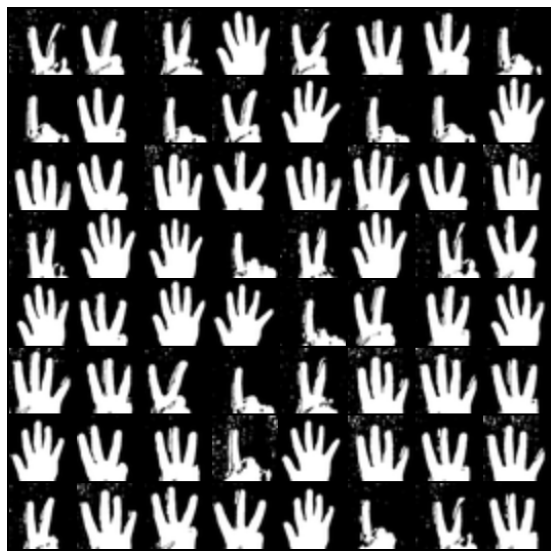

In [8]:
BATCH_SIZE = 64
IMG_SIZE = 64

norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Means, Stds
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means


dataset = datasets.ImageFolder(root="/content/drive/MyDrive/NNDL/HW6/Dataset",transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def show_batch(data_loader):
    for images, labels in data_loader:
        plt.subplots(figsize=(12, 10))
        plt.axis("off")
        raw_images = unnorm(images, *norm)
        plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(dataloader)

# WGAN

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.cnn(x)

generator = Generator()
generator.to(DEVICE)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
generator = Generator()
generator.to(DEVICE)
discriminator = Discriminator()
discriminator.to(DEVICE)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)
real_label = 1.
fake_label = 0.
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005, weight_decay=1e-5)
generator_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 - Discriminator_Loss: 0.000064 - Generator_Loss: -0.000466


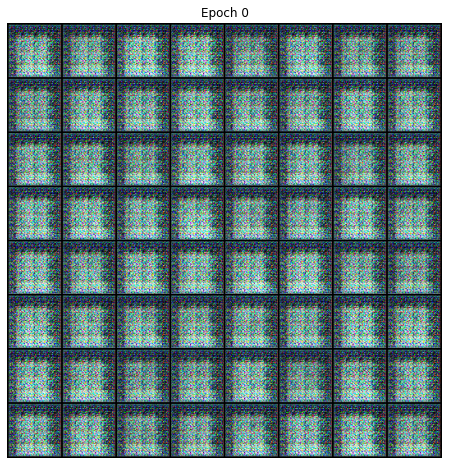

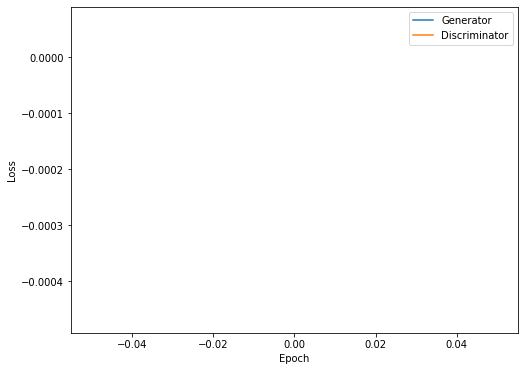

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 - Discriminator_Loss: -0.000194 - Generator_Loss: -0.000510


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 - Discriminator_Loss: -0.000194 - Generator_Loss: -0.000470


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 - Discriminator_Loss: -0.000229 - Generator_Loss: -0.000364


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 - Discriminator_Loss: -0.000351 - Generator_Loss: -0.000225


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 - Discriminator_Loss: -0.000517 - Generator_Loss: -0.000066


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 - Discriminator_Loss: -0.000679 - Generator_Loss: 0.000095


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 - Discriminator_Loss: -0.000614 - Generator_Loss: 0.000191


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 - Discriminator_Loss: -0.000833 - Generator_Loss: 0.000317


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 - Discriminator_Loss: -0.000849 - Generator_Loss: 0.000203


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 - Discriminator_Loss: -0.001106 - Generator_Loss: 0.000279


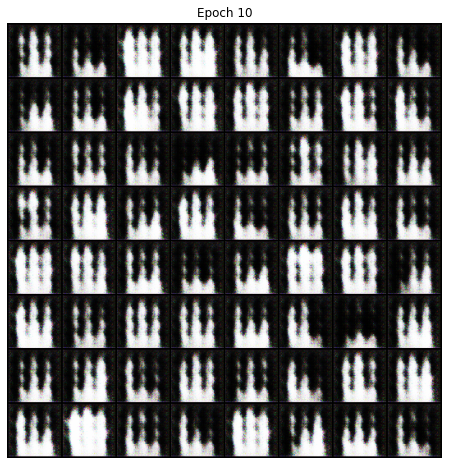

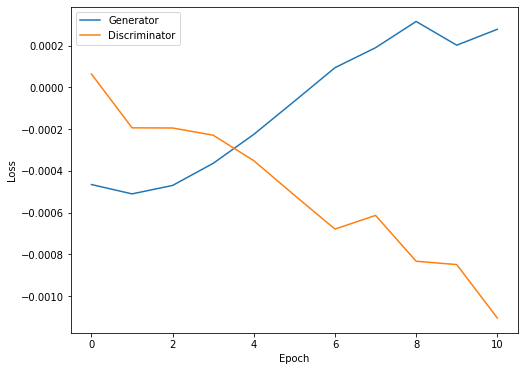

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 - Discriminator_Loss: -0.001174 - Generator_Loss: 0.000544


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 - Discriminator_Loss: -0.001345 - Generator_Loss: 0.000711


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 - Discriminator_Loss: -0.001437 - Generator_Loss: 0.000982


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 - Discriminator_Loss: -0.001904 - Generator_Loss: 0.001374


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 - Discriminator_Loss: -0.001972 - Generator_Loss: 0.001454


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 - Discriminator_Loss: -0.002316 - Generator_Loss: 0.001600


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 - Discriminator_Loss: -0.002473 - Generator_Loss: 0.001340


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 - Discriminator_Loss: -0.002824 - Generator_Loss: 0.001725


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 - Discriminator_Loss: -0.002962 - Generator_Loss: 0.001564


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 - Discriminator_Loss: -0.003083 - Generator_Loss: 0.001813


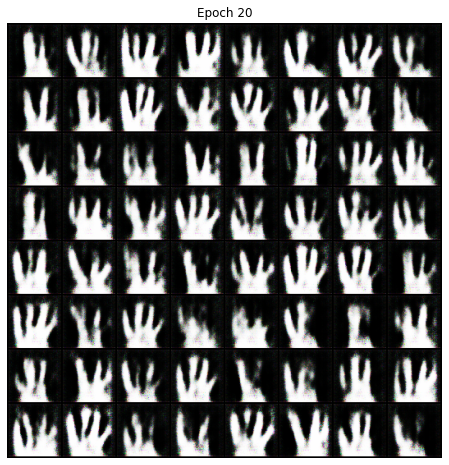

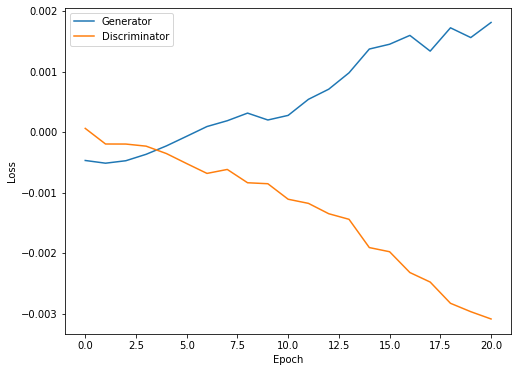

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 - Discriminator_Loss: -0.003033 - Generator_Loss: 0.001948


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 - Discriminator_Loss: -0.003038 - Generator_Loss: 0.001693


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 - Discriminator_Loss: -0.002866 - Generator_Loss: 0.001468


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 - Discriminator_Loss: -0.002799 - Generator_Loss: 0.001534


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 - Discriminator_Loss: -0.002854 - Generator_Loss: 0.001519


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 - Discriminator_Loss: -0.002773 - Generator_Loss: 0.001399


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 - Discriminator_Loss: -0.002926 - Generator_Loss: 0.001677


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 - Discriminator_Loss: -0.003158 - Generator_Loss: 0.001616


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 - Discriminator_Loss: -0.003565 - Generator_Loss: 0.001623


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 - Discriminator_Loss: -0.003324 - Generator_Loss: 0.001723


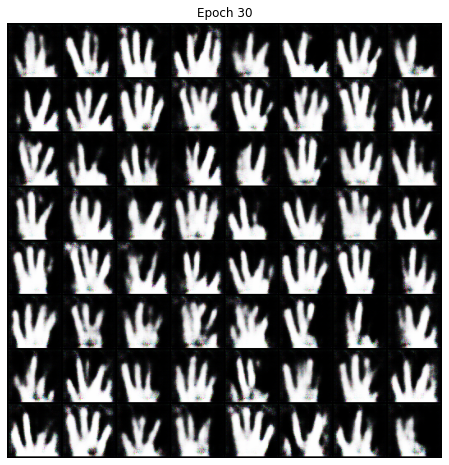

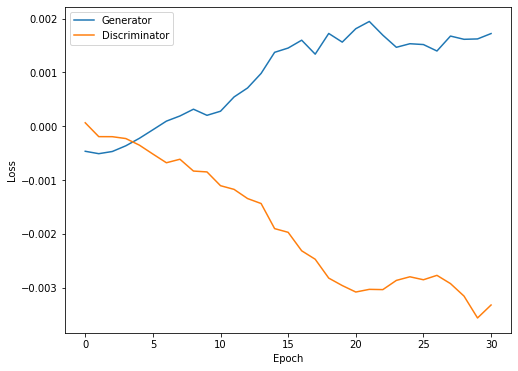

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 - Discriminator_Loss: -0.003762 - Generator_Loss: 0.001961


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 - Discriminator_Loss: -0.003813 - Generator_Loss: 0.002033


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 - Discriminator_Loss: -0.004021 - Generator_Loss: 0.001833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 - Discriminator_Loss: -0.004073 - Generator_Loss: 0.002018


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 - Discriminator_Loss: -0.003987 - Generator_Loss: 0.002143


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 - Discriminator_Loss: -0.004198 - Generator_Loss: 0.002235


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 - Discriminator_Loss: -0.004489 - Generator_Loss: 0.002167


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 - Discriminator_Loss: -0.004537 - Generator_Loss: 0.002835


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 - Discriminator_Loss: -0.005126 - Generator_Loss: 0.002833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 - Discriminator_Loss: -0.004551 - Generator_Loss: 0.002899


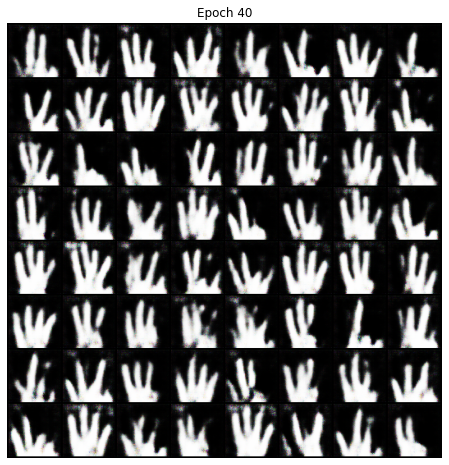

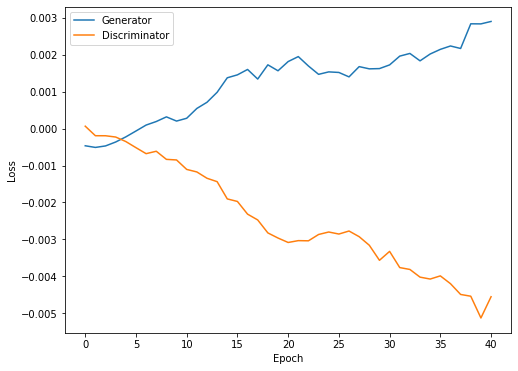

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 - Discriminator_Loss: -0.004053 - Generator_Loss: 0.002064


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 - Discriminator_Loss: -0.004704 - Generator_Loss: 0.002780


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 - Discriminator_Loss: -0.004991 - Generator_Loss: 0.002793


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 - Discriminator_Loss: -0.004998 - Generator_Loss: 0.003343


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 - Discriminator_Loss: -0.005261 - Generator_Loss: 0.003373


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 - Discriminator_Loss: -0.004989 - Generator_Loss: 0.002606


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 - Discriminator_Loss: -0.005205 - Generator_Loss: 0.002789


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 - Discriminator_Loss: -0.005257 - Generator_Loss: 0.003487


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 - Discriminator_Loss: -0.004884 - Generator_Loss: 0.002297


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 - Discriminator_Loss: -0.005053 - Generator_Loss: 0.003035


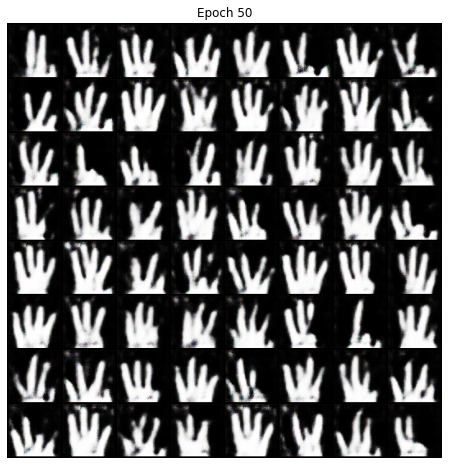

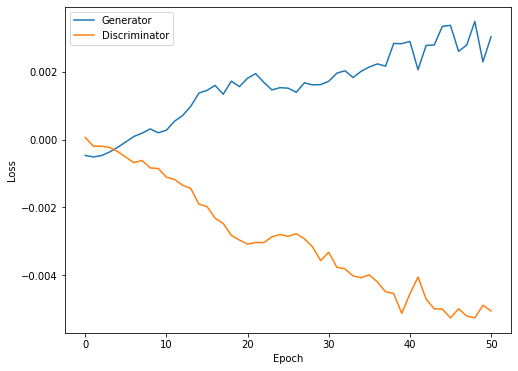

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 - Discriminator_Loss: -0.005351 - Generator_Loss: 0.003092


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 - Discriminator_Loss: -0.005564 - Generator_Loss: 0.003530


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 - Discriminator_Loss: -0.004932 - Generator_Loss: 0.002702


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 - Discriminator_Loss: -0.005462 - Generator_Loss: 0.003075


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 - Discriminator_Loss: -0.005148 - Generator_Loss: 0.002726


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 - Discriminator_Loss: -0.005320 - Generator_Loss: 0.003344


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 - Discriminator_Loss: -0.005695 - Generator_Loss: 0.003346


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 - Discriminator_Loss: -0.005928 - Generator_Loss: 0.003241


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 - Discriminator_Loss: -0.005497 - Generator_Loss: 0.003486


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 - Discriminator_Loss: -0.005112 - Generator_Loss: 0.002599


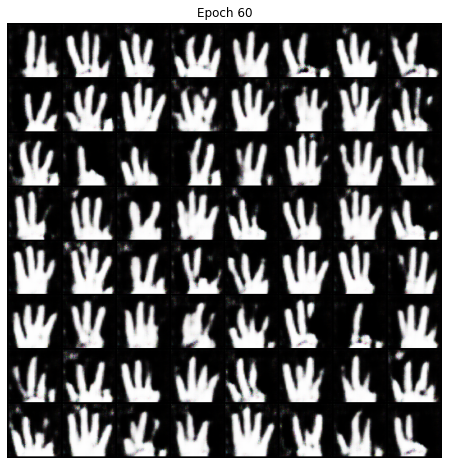

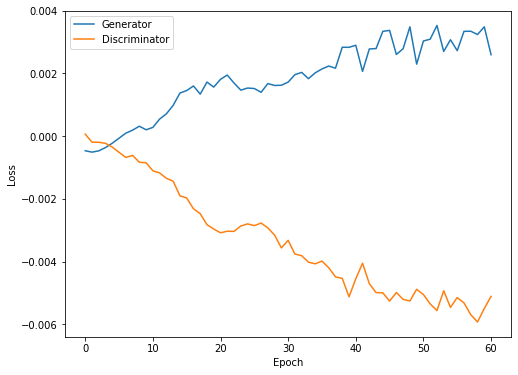

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 - Discriminator_Loss: -0.006037 - Generator_Loss: 0.003572


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 - Discriminator_Loss: -0.005186 - Generator_Loss: 0.003032


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 - Discriminator_Loss: -0.005407 - Generator_Loss: 0.003221


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 - Discriminator_Loss: -0.005886 - Generator_Loss: 0.003928


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 - Discriminator_Loss: -0.005231 - Generator_Loss: 0.002993


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 - Discriminator_Loss: -0.006161 - Generator_Loss: 0.003484


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 - Discriminator_Loss: -0.006202 - Generator_Loss: 0.003932


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 - Discriminator_Loss: -0.005293 - Generator_Loss: 0.003133


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 - Discriminator_Loss: -0.005679 - Generator_Loss: 0.003221


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 - Discriminator_Loss: -0.006364 - Generator_Loss: 0.003645


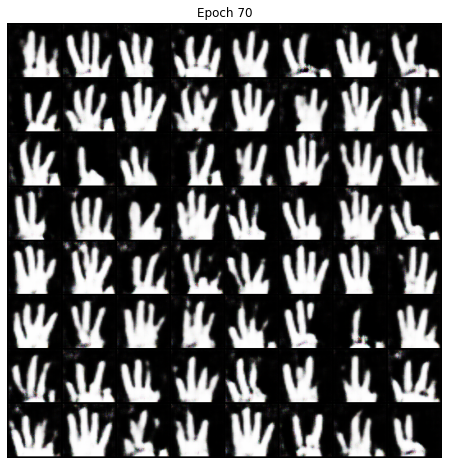

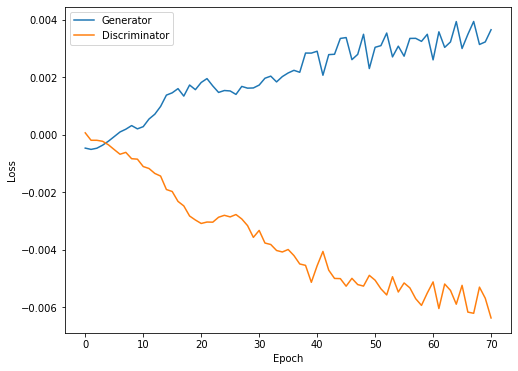

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 - Discriminator_Loss: -0.006287 - Generator_Loss: 0.003781


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 - Discriminator_Loss: -0.006036 - Generator_Loss: 0.003502


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 - Discriminator_Loss: -0.005844 - Generator_Loss: 0.002965


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 - Discriminator_Loss: -0.006063 - Generator_Loss: 0.003573


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 - Discriminator_Loss: -0.006705 - Generator_Loss: 0.003996


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 - Discriminator_Loss: -0.006333 - Generator_Loss: 0.003520


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 - Discriminator_Loss: -0.006528 - Generator_Loss: 0.003791


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 - Discriminator_Loss: -0.006088 - Generator_Loss: 0.003969


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 - Discriminator_Loss: -0.006681 - Generator_Loss: 0.003591


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 - Discriminator_Loss: -0.007224 - Generator_Loss: 0.004122


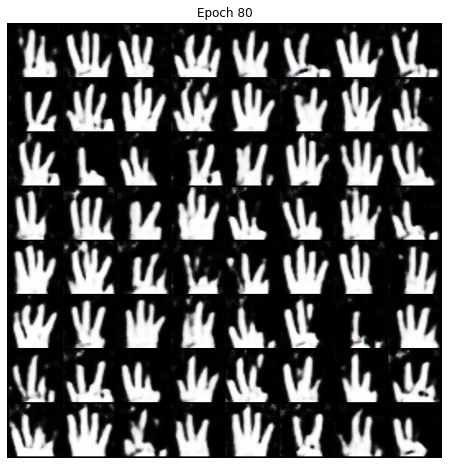

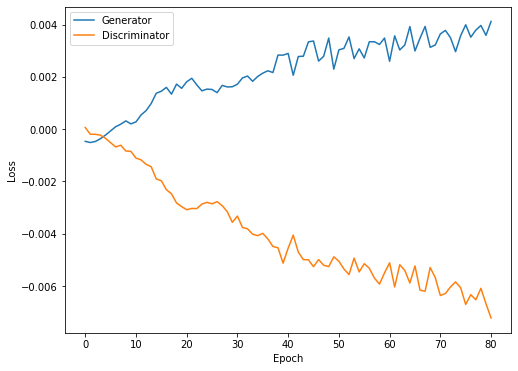

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 - Discriminator_Loss: -0.005767 - Generator_Loss: 0.003526


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 - Discriminator_Loss: -0.006442 - Generator_Loss: 0.004082


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 - Discriminator_Loss: -0.005854 - Generator_Loss: 0.003927


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 - Discriminator_Loss: -0.006421 - Generator_Loss: 0.003812


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 - Discriminator_Loss: -0.006949 - Generator_Loss: 0.003606


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 - Discriminator_Loss: -0.006972 - Generator_Loss: 0.003793


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 - Discriminator_Loss: -0.006745 - Generator_Loss: 0.004032


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 - Discriminator_Loss: -0.007144 - Generator_Loss: 0.003979


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 - Discriminator_Loss: -0.006035 - Generator_Loss: 0.003174


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [25]:
img_list = []
g_losses, d_losses = [], []
total = 0

def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(10, 8))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    raw_images = unnorm(imgs, *norm)
    plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1),cmap='gray')
    plt.show()

for epoch in tqdm(range(101)):
    g_loss = 0.0
    d_loss = 0.0
    total = 0
    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        for _ in range(1):
            # Train Discriminator
            discriminator.zero_grad()
            # Real
            real_images = data[0].to(DEVICE)
            batch_size = real_images.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
            output_real = discriminator(real_images).view(-1)
            # Fake
            noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)
            fake = generator(noise)
            label.fill_(fake_label)
            output_fake = discriminator(fake.detach()).view(-1)
            d_wloss = torch.mean(output_fake - output_real)
            d_wloss.backward()
            discriminator_optimizer.step()

            for params in discriminator.parameters():
                params.data.clamp_(-0.01, +0.01)

        # Train Generator
        generator.zero_grad()
        output = discriminator(fake).view(-1)
        g_wloss = -torch.mean(output)
        g_wloss.backward()
        generator_optimizer.step()

        g_loss += g_wloss.item()
        d_loss += d_wloss.item()
        total += batch_size

    avg_g_loss = g_loss / total
    g_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    d_losses.append(avg_d_loss)

    print(f"Epoch: {epoch + 1} - Discriminator_Loss: {avg_d_loss:.6f} - Generator_Loss: {avg_g_loss:.6f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    imgs = vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True)
    img_list.append(imgs)
    if epoch % 10 == 0:
        plot_images(fake, epoch)
        plot_loss(g_losses, d_losses)